In [1]:
import numpy as np
import pandas as pd
import pickle
from zipfile import ZipFile
import mne

# graphical libs
from matplotlib import pyplot as plt
%matplotlib widget

# графические библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ml libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import f1_score, classification_report, mean_squared_error
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

import tensorflow as tf
from keras import backend as K


from scipy.signal import savgol_filter, filtfilt, butter

import optuna
from optuna.samplers import TPESampler

# set number of rows ti display
#pd.set_option("display.max_rows", 9, "display.max_columns", 9)

# lib for interpretator processing
import sys, os
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Hide output
from IPython.display import clear_output

# Model serialization
import pickle

import serial
import time

In [2]:
# Set requirements
#!pip install -qr ../requirements.txt

In [3]:
# Библиотека вызова функций, специально разработанных для данного ноутбука
sys.path.insert(1, '../')

from utils.config_reader import config_reader
from utils.functions import get_mse, preprocessing_0, preprocessing_1, reset_random_seeds, callbacks 
from utils.figures import get_signals_plot, get_signals_comparison_plot, plot_history #get_all_sensors_plot, 

# import constants from the config
config = config_reader('../config/data_config.json') 

# path for data
PATH = config.PATH

# path for models
PATH_MODEL = config.PATH_FOR_MODEL

# if not os.path.exists(PATH_FOR_MODEL):
#     os.mkdir(PATH_FOR_MODEL) 

In [4]:
import random

# Fix seed
seed_value = config.seed_value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 1. initiate random seed in Python
random.seed(seed_value)

# 2. initiate random seed in Numpy
np.random.seed(seed_value)

# 3. initiate random seed in Optuna
sampler = TPESampler(seed=seed_value) # fix random seed

# 4. initiate random seed in tensorflow 
tf.random.set_seed(seed_value)
 
# 5. Конфигурация Tenzorflow
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [5]:
# Reading files with ".npy" and 'csv' extension and saving them to the dictionnary "mounts"
mounts = dict()

with ZipFile(os.path.join(PATH, 'data.zip')) as myzip:
    for file in myzip.namelist():
            mounts[f"{file[:-4]}".format(file)] = pd.read_csv(myzip.open(file), index_col=0)

mounts.keys()

dict_keys(['free_movements', 'gestures_protocol', 'gestures_test', 'gestures_train'])

In [6]:
free_movements = mounts['free_movements']

print(free_movements.shape)
free_movements.head()

(20990, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
140,1203,22,1594,123,10,2390,24,32,1848,40,...,-18,40,53,55,48,41,0,1000,0,8881644
141,1204,0,1598,136,2,2396,28,28,1847,42,...,-12,40,53,55,48,41,0,1000,0,8881677
142,1203,0,1599,132,14,2398,20,30,1851,45,...,-10,40,53,55,48,41,0,1000,0,8881710
143,1202,27,1601,115,11,2402,30,22,1858,44,...,-10,40,53,55,48,41,0,1000,0,8881743
144,1207,0,1601,109,4,2404,28,27,1857,43,...,-10,40,53,55,48,41,0,1000,0,8881776


In [7]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# [y target]   'ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5' - координаты пальцев в перчатке GLOVE
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом (не используется для свободных движений)
# 'ts' - метка времени
free_movements.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

### Gestures train and test

In [8]:
gestures_train = mounts['gestures_train']

print(gestures_train.shape)
gestures_train.head()

(33172, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,1605,0,1739,94,6,2618,30,29,2058,40,...,-1,19,25,22,11,0,0,1000,0,6492378
1,1604,8,1738,94,7,2618,30,28,2062,40,...,-14,19,25,21,11,0,0,1000,0,6492411
2,1607,9,1739,94,7,2624,32,28,2064,43,...,-17,19,25,21,11,0,0,1000,0,6492444
3,1597,2,1743,93,5,2612,31,31,2052,39,...,-15,19,25,21,11,0,0,1000,0,6492477
4,1595,7,1722,91,8,2603,32,26,2052,37,...,-10,19,25,21,11,0,0,1000,0,6492510


In [9]:
gestures_test = mounts['gestures_test']

print(gestures_test.shape)
gestures_test.head()

(8168, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
33172,1469,11,1858,99,4,2552,29,39,2190,38,...,-3,9,12,4,1,0,0,1000,433,7587054
33173,1460,11,1857,99,6,2549,31,32,2190,41,...,-3,9,12,4,1,0,0,1000,433,7587087
33174,1471,9,1860,101,6,2554,29,35,2193,39,...,-6,10,12,4,1,0,0,1000,433,7587120
33175,1467,8,1856,98,0,2549,27,36,2190,40,...,-12,10,12,4,1,0,0,1000,433,7587153
33176,1471,6,1859,99,3,2554,28,36,2187,40,...,-19,10,12,4,1,0,0,1000,433,7587186


In [10]:
# Обозначение колонок для удобства доступа
OMG_CH = [str(i) for i in range(50)]

ACC_CH = config.ACC_CH
GYR_CH = config.GYR_CH
# ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
GLOVE_CH = config.GLOVE_CH[:-1] # Датчик 'ENC5' не используем
#GLOVE_CH = GLOVE_CH
BUTTON_SYNC_TS_CH = config.BUTTON_SYNC_TS_CH

#assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == free_movements.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"GLOVE_CH: {list(GLOVE_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

col_diff_names = [x + '_DIFF' for x in OMG_CH]

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
GLOVE_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


### Protocol

In [11]:
gestures_protocol = mounts['gestures_protocol']
gestures_protocol.head(10)

,Thumb,Index,Middle,Ring,Pinky,id
epoch,,,,,,
0,0,0,0,0,0,1
1,100,0,0,0,0,2
2,0,0,0,0,0,3
3,0,0,100,100,100,4
4,0,0,0,0,0,5
5,100,100,0,0,0,6
6,0,0,0,0,0,7
7,100,100,100,100,100,8
8,0,0,0,0,0,9


In [12]:
display(gestures_train['SYNC'].head(2), gestures_train['SYNC'].tail(2))

0    0
1    0
Name: SYNC, dtype: int64

33170    432
33171    432
Name: SYNC, dtype: int64

In [13]:
# Смотрим все признаки вместе (для информации) 
gestures_train_ext = pd.merge(
    gestures_train,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_test_ext = pd.merge(
    gestures_test,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)
gestures_train_ext.head()

,0,1,2,3,4,5,6,7,8,9,...,ENC5,BUTTON,SYNC,ts,Thumb,Index,Middle,Ring,Pinky,id
0,1605,0,1739,94,6,2618,30,29,2058,40,...,0,1000,0,6492378,0,0,0,0,0,1
1,1604,8,1738,94,7,2618,30,28,2062,40,...,0,1000,0,6492411,0,0,0,0,0,1
2,1607,9,1739,94,7,2624,32,28,2064,43,...,0,1000,0,6492444,0,0,0,0,0,1
3,1597,2,1743,93,5,2612,31,31,2052,39,...,0,1000,0,6492477,0,0,0,0,0,1
4,1595,7,1722,91,8,2603,32,26,2052,37,...,0,1000,0,6492510,0,0,0,0,0,1


In [14]:
gestures_train['ts'].head()

0    6492378
1    6492411
2    6492444
3    6492477
4    6492510
Name: ts, dtype: int64

## Composition of X_train

In [34]:
X_train_raw, X_test_raw = gestures_train[OMG_CH].values, gestures_test[OMG_CH].values #56
# Предобработка скользящим окном
#X_train, X_test = X_train.rolling(window=3).mean().dropna(axis=0), X_test.rolling(window=3).mean().dropna(axis=0)

display('X_train', pd.DataFrame(X_train_raw, columns=OMG_CH).head(2))

y_train, y_test = gestures_train[GLOVE_CH], gestures_test[GLOVE_CH]

# Предобработка скользящим окном
#y_train, y_test =  y_train.iloc[2:,:], y_test.iloc[2:,]
display('y_train', pd.DataFrame(y_train, ).head(2), 'y_test', y_test.head(2))

'X_train'

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1605,0,1739,94,6,2618,30,29,2058,40,...,20,9,8,32,4,9,22,4,9,48
1,1604,8,1738,94,7,2618,30,28,2062,40,...,20,10,10,31,7,11,24,6,7,18


'y_train'

,ENC0,ENC1,ENC2,ENC3,ENC4
0,19,25,22,11,0
1,19,25,21,11,0


'y_test'

,ENC0,ENC1,ENC2,ENC3,ENC4
33172,9,12,4,1,0
33173,9,12,4,1,0


In [16]:
X_free, y_free = free_movements.iloc[:,0:50], free_movements[GLOVE_CH]

display(X_free.head(2),'X_free', X_free.shape, y_free.head(2),y_free.shape)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
140,1203,22,1594,123,10,2390,24,32,1848,40,...,13,10,9,32,5,9,24,5,7,9
141,1204,0,1598,136,2,2396,28,28,1847,42,...,18,5,12,26,10,11,17,1,5,6


'X_free'

(20990, 50)

,ENC0,ENC1,ENC2,ENC3,ENC4
140,40,53,55,48,41
141,40,53,55,48,41


(20990, 5)

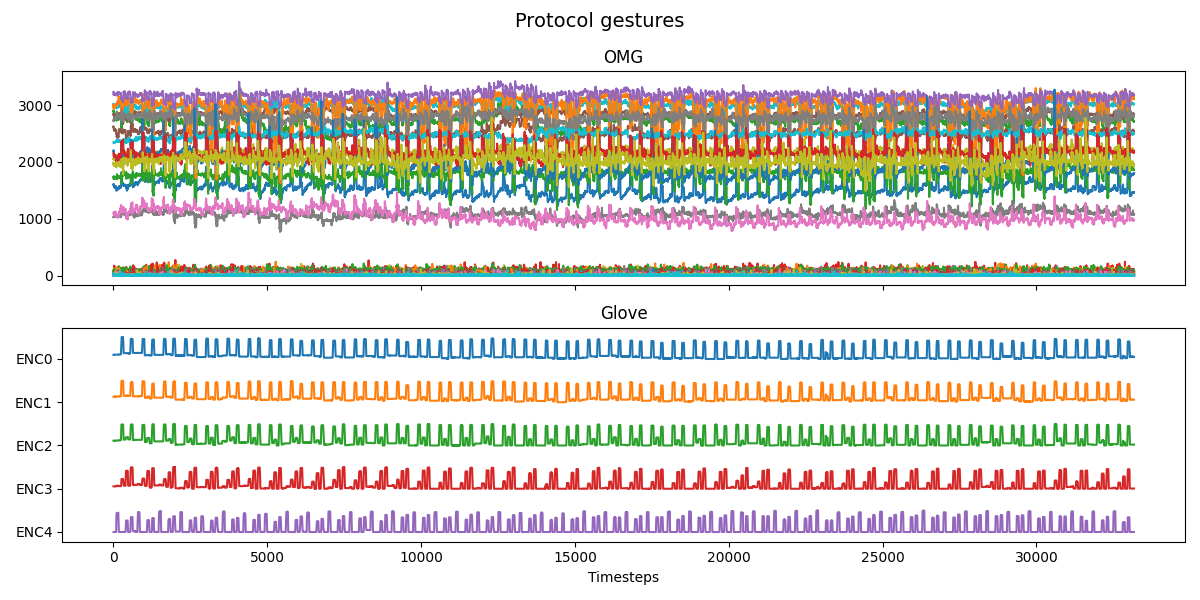

In [17]:
get_signals_plot(X_train_raw, y_train, 'Protocol gestures')

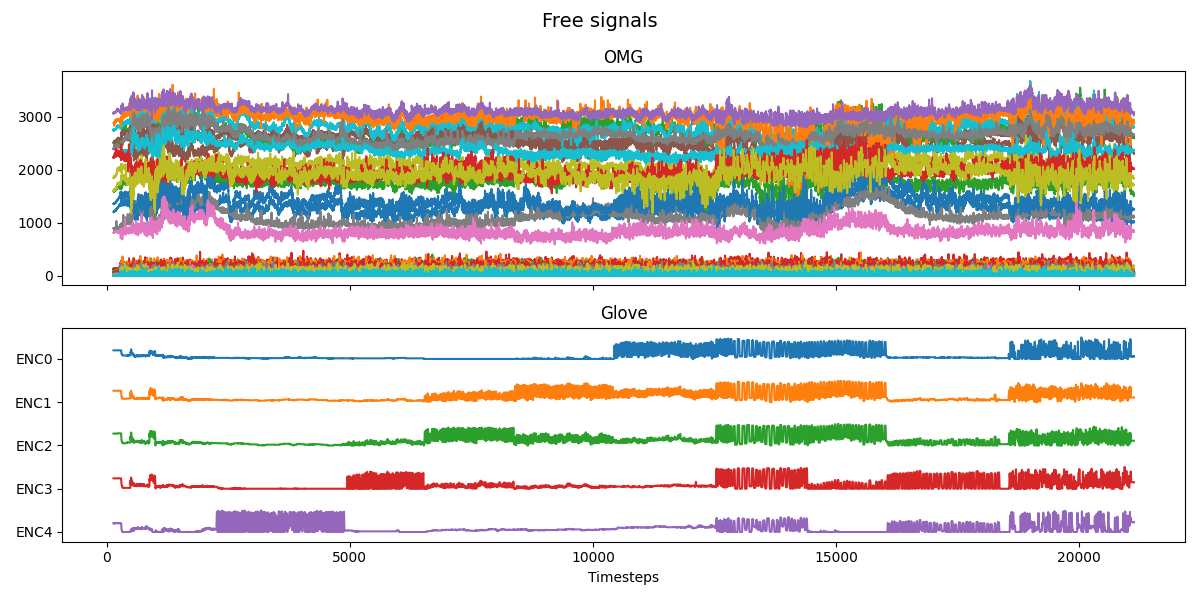

In [18]:
get_signals_plot(X_free, y_free, 'Free signals')

# Preprocessing

In [19]:
# Smoothing of sensor signals
X_train = np.transpose([savgol_filter(X_train_raw.iloc[:,i], window_length=60, polyorder=4) for i in range(X_train_raw.shape[1])]) 
X_test = np.transpose([savgol_filter(X_test_raw.iloc[:,i], window_length=60, polyorder=4) for i in range(X_test_raw.shape[1])])
X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)

In [20]:
def add_diff(arr, shift_=1):
    diff_arr = np.vstack([np.zeros((shift_, arr.shape[1])), (arr-np.roll(arr, shift_, axis=0))[shift_:]])
    return np.hstack([arr, diff_arr])

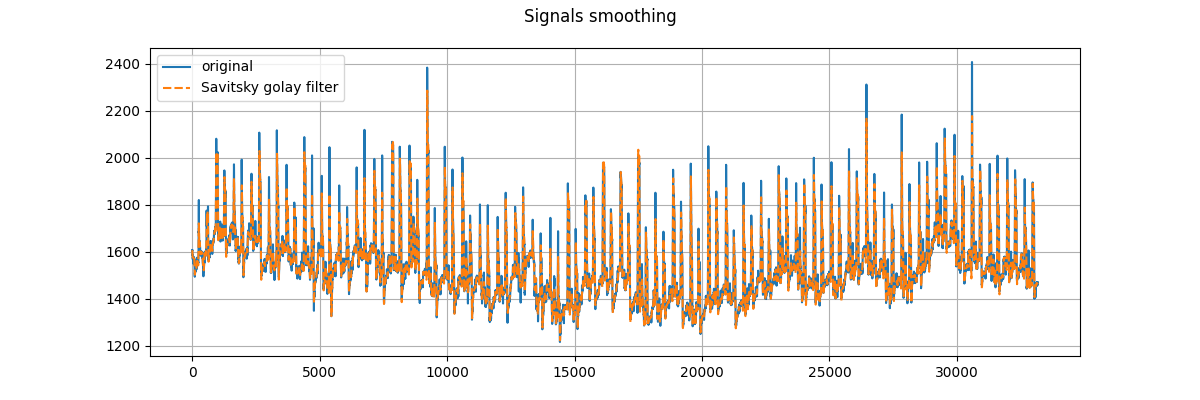

In [21]:
# Smoothing of sensor 0 signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
temp = pd.DataFrame({
    'original':X_train_raw.iloc[:,0], 
    'Savitsky golay filter':X_train.iloc[:,0], 
    #'digital filter':X_train.iloc[:,0]
})
sns.lineplot(temp)
plt.suptitle('Signals smoothing')
plt.grid()

In [22]:
# gestures_trn_diff = np.vstack([np.diff(X_train, axis=0)[0], np.diff(X_train, axis=0)])
# gestures_trn_diff = pd.DataFrame(gestures_trn_diff, columns=col_diff_names, index=X_train.index)
# gestures_tst_diff = np.vstack([np.diff(X_test, axis=0)[0], np.diff(X_test, axis=0)])
# gestures_tst_diff = pd.DataFrame(gestures_tst_diff, columns=col_diff_names, index=X_test.index)
# COLS = pd.concat([X_train, gestures_trn_diff], axis=1).columns

# X_train, X_test = pd.concat([X_train, gestures_trn_diff], axis=1), pd.concat([X_test, gestures_tst_diff], axis=1)

In [23]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test) #  pd.DataFrame(X_train, columns=X_train.columns)

# Modeling

### Linear regression

MSE metrics for Test: 
--------


ENC0     64.762977
ENC1     37.368756
ENC2     42.720984
ENC3    183.218781
ENC4    364.703967
dtype: float64

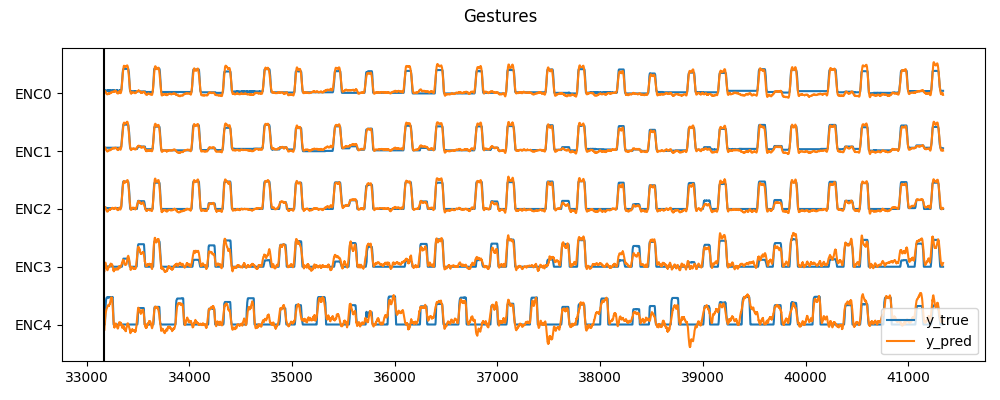

In [24]:
# Creation an instance
lin = LinearRegression()

# Train the Model
lin.fit(X_train, y_train)

# Predict target values
y_pred= pd.DataFrame(lin.predict(X_test), columns=GLOVE_CH, index=gestures_test['ts']).round()

# Display metrics
get_mse(y_test, y_pred)

# Display comparison plot
get_signals_comparison_plot(y_train, y_test, y_pred=y_pred, only_test=1)

> Метрики Теста:
``` Python
ENC0     64.762977
ENC1     37.368756
ENC2     42.720984
ENC3    183.218781
ENC4    364.703967
```

In [25]:
# Save model to the given path in the pkl format
model_name = 'lin'
full_path = os.path.join(config.PATH_MODEL, model_name + '.pkl')  
 
with open(full_path, 'wb') as f:
    pickle.dump(lin, f)

### Random forest

MSE metrics for Train: 
--------


ENC0    0.390872
ENC1    0.332811
ENC2    0.396871
ENC3    1.247196
ENC4    1.520710
dtype: float64

MSE metrics for Test: 
--------


ENC0     35.030852
ENC1     39.472209
ENC2     36.455803
ENC3    145.028526
ENC4    352.105656
dtype: float64

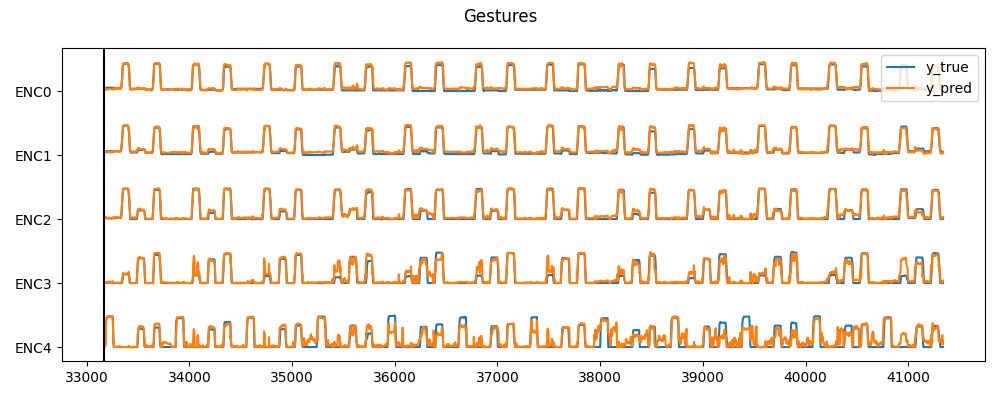

In [26]:
rfr = RandomForestRegressor(
    n_estimators=300, 
    verbose=0, n_jobs=-1,
    #max_depth=6, min_samples_leaf=2,
    random_state=seed_value)

# Model training
rfr.fit(X_train, y_train)

# Prediction target values and transforming it to a DataFrame
y_pred = pd.DataFrame(rfr.predict(X_test), columns=GLOVE_CH, index=gestures_test['ts']).round()
y_pred_train = pd.DataFrame(rfr.predict(X_train), columns=GLOVE_CH, index=gestures_train['ts']).round()

# Display metrics
get_mse(y_test, y_pred, y_train, y_pred_train)

# Display comparison plot
get_signals_comparison_plot(y_train, y_test, y_pred, only_test=1) #

### Нейронная сеть

In [27]:
reset_random_seeds(seed_value)

#np.expand_dims(X_train, axis=0).shape

n_timesteps = None
b_size = 64
n_channels = X_train.shape[1] # gestures_train[[*OMG_CH, *ACC_CH, *GYR_CH]].shape[1] 
output_units = y_train.shape[1]

# choose architecture
input_layer = x = tf.keras.layers.Input(shape=(n_timesteps, n_channels))
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LSTM(units=100, 
                         #input_shape=(1, 5),
                         #return_state=True,
                         recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3)
                         )(x) #LSTM
#x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.3)(x) #0.3
output_layer = tf.keras.layers.Dense(units=output_units, activation='elu')(x)

model = tf.keras.Model(
    inputs=input_layer,
    outputs=output_layer,
    name="model_RNN"
    )

model.summary()

tf.keras.backend.clear_session()

reset_random_seeds(seed_value)

model.compile(
    loss="mean_squared_error", 
    metrics=['mse'], 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) # AdamW
    )

callbacks_list = callbacks(1e-04)

Model: "model_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 50)]        0         
                                                                 
 batch_normalization (BatchN  (None, None, 50)         200       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 61,105
Trainable params: 61,005
Non-trainable params: 100
___________________________________________________

In [28]:
history = model.fit(
            x = np.expand_dims(X_train, 1), 
            y = y_train,
            batch_size=b_size,
            validation_split=0.2,
            epochs=1500,
            verbose=1,          
            callbacks=callbacks_list
        )

Epoch 1/1500
407/415 [============================>.] - ETA: 0s - loss: 1106.6145 - mse: 1106.4733
Epoch 1: val_mse improved from inf to 686.36255, saving model to ../models\best_model.hdf5
415/415 [==============================] - 4s 5ms/step - loss: 1099.7886 - mse: 1099.6499 - val_loss: 686.3674 - val_mse: 686.3625 - lr: 0.0010
Epoch 2/1500
406/415 [============================>.] - ETA: 0s - loss: 530.9981 - mse: 530.9932
Epoch 2: val_mse improved from 686.36255 to 387.64615, saving model to ../models\best_model.hdf5
415/415 [==============================] - 1s 4ms/step - loss: 528.7582 - mse: 528.7533 - val_loss: 387.6513 - val_mse: 387.6461 - lr: 0.0010
Epoch 3/1500
412/415 [============================>.] - ETA: 0s - loss: 327.4619 - mse: 327.4572
Epoch 3: val_mse improved from 387.64615 to 252.11317, saving model to ../models\best_model.hdf5
415/415 [==============================] - 1s 4ms/step - loss: 327.2293 - mse: 327.2245 - val_loss: 252.1179 - val_mse: 252.1132 - lr: 0

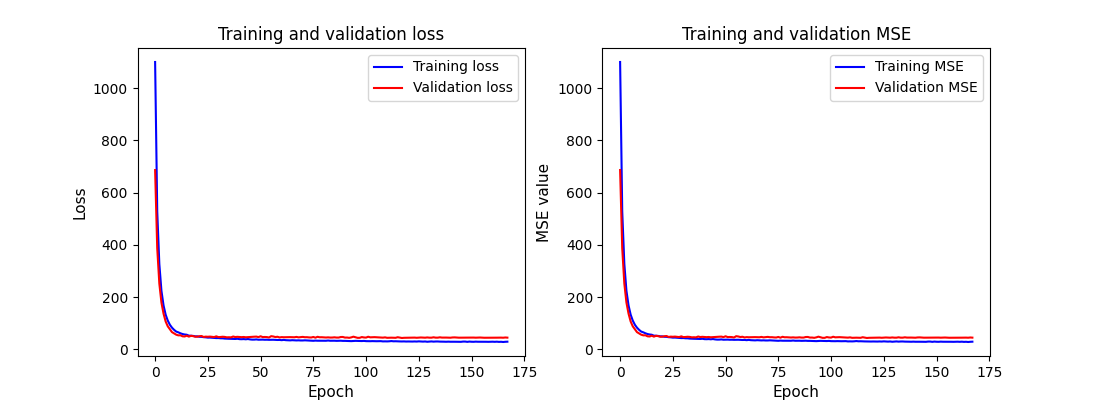

In [29]:
plot_history(history)

## Prediction

256/256 [==============================] - 0s 1ms/step
MSE metrics for Test: 
--------


ENC0     22.065643
ENC1     25.037613
ENC2     37.758126
ENC3     85.777369
ENC4    126.715139
dtype: float64

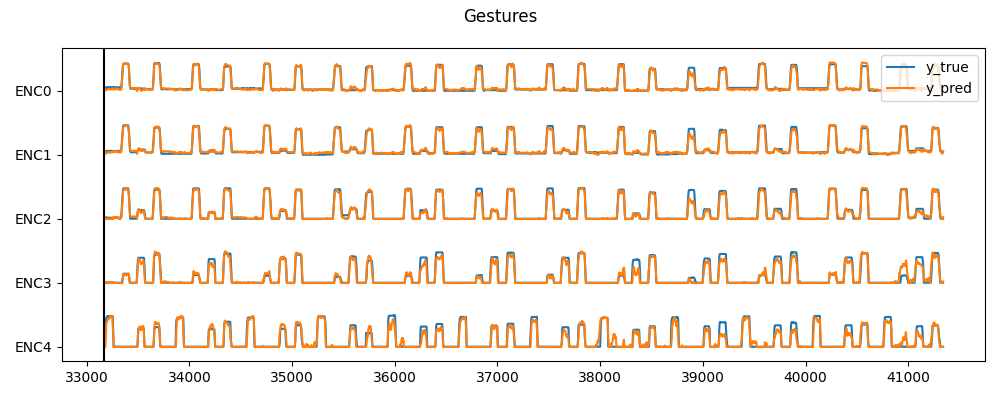

In [30]:
y_pred_train = model.predict(np.expand_dims(X_train, 1)) # [*OMG_CH, *ACC_CH, *GYR_CH] # ---
y_pred_train = pd.DataFrame(y_pred_train, columns=GLOVE_CH, index=gestures_train['ts']) # ---

y_pred_test = model.predict(np.expand_dims(X_test, 1)) #[*OMG_CH, *ACC_CH, *GYR_CH]
y_pred_test = pd.DataFrame(y_pred_test, columns=GLOVE_CH, index=gestures_test['ts'])

# Display metrics
get_mse(y_test, y_pred_test)

# Display comparison plot
get_signals_comparison_plot(y_train, y_test, y_pred=y_pred_test, only_test=1)

> Метрики нейронной сети со сглаживанием:
``` Python
ENC0     22.065643
ENC1     25.037613
ENC2     37.758126
ENC3     85.777369
ENC4    126.715139
```

## Postprocessing

In [31]:
y_pred_train[GLOVE_CH] = np.where(y_pred_train[GLOVE_CH] < 0, 0, y_pred_train[GLOVE_CH]) 
y_pred_train[GLOVE_CH] = np.where(y_pred_train[GLOVE_CH] > 100, 100, y_pred_train[GLOVE_CH]) 
y_pred_test[GLOVE_CH] = np.where(y_pred_test[GLOVE_CH] < 0, 0, y_pred_test[GLOVE_CH])
y_pred_test[GLOVE_CH] = np.where(y_pred_test[GLOVE_CH] > 100, 100, y_pred_test[GLOVE_CH])

# Display metrics
get_mse(y_test, y_pred_test, y_train, y_pred_train)

MSE metrics for Train: 
--------


ENC0     7.860484
ENC1     6.747929
ENC2     8.580138
ENC3    15.394174
ENC4    27.168726
dtype: float64

MSE metrics for Test: 
--------


ENC0     21.990509
ENC1     25.030558
ENC2     37.350447
ENC3     84.971263
ENC4    125.900298
dtype: float64

In [ ]:
preproc_coef = 0.57

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*preproc_coef + prev*(1-preproc_coef) # Holt-Winters filter 0.1i 0.9i-1
    return y

y_pred_test_proc = np.zeros_like(y_pred_test)
y_pred_test_proc[0] = y_pred_test.iloc[0]


for i in range(1, len(y_pred_test)):
    y_pred_test_proc[i] = postprocessing(y_pred_test.iloc[i], y_pred_test.iloc[i-1])

y_pred_test_proc = pd.DataFrame(y_pred_test_proc, columns = [GLOVE_CH])

y_pred_test_proc[GLOVE_CH] = np.where(y_pred_test_proc[GLOVE_CH] < 0, 0, y_pred_test_proc[GLOVE_CH])
y_pred_test_proc[GLOVE_CH] = np.where(y_pred_test_proc[GLOVE_CH] > 100, 100, y_pred_test_proc[GLOVE_CH])

# Display metrics
get_mse(y_test, y_pred_test_proc)

MSE metrics for Test: 
--------


ENC0     22.019017
ENC1     25.279408
ENC2     37.892737
ENC3     83.524072
ENC4    126.268813
dtype: float64

# Real-time inference

In [ ]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [ ]:
def preprocessing(x):
    # x - sample vector
    y = np.transpose([savgol_filter(x[:,i], window_length=60, polyorder=4) for i in range(x.shape[1])])
    return y

X_train, X_test = preprocessing(X_train), preprocessing(X_test)

def inference(x, model):
    y = model.predict([x])[0] 
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [ ]:
df_sim = gestures_test.copy()
# df_sim = free_movements.iloc[:10000]
print(df_sim.shape)

(8168, 65)


In [ ]:
TIMEOUT = 0.033
DEBUG = True
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 1000, SYNC: 539, TS: 7856565
[ 7 12  7  6 79  0]


In [ ]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (8168, 50)
enc_sample.shape = (8168, 6)
sample_preprocessed.shape = (8168, 50)
y_predicted.shape = (8168, 6)
y_postprocessed.shape = (8168, 6)
y_commands.shape = (8168, 6)


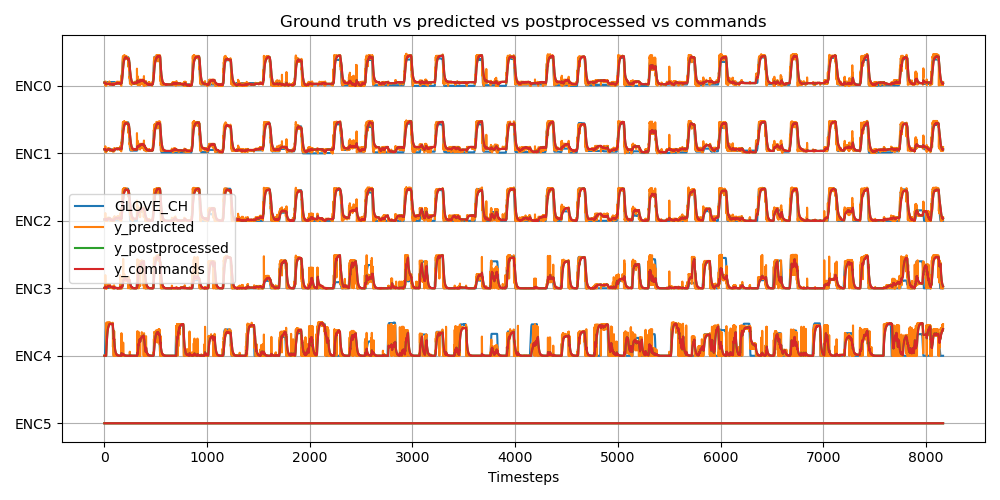

In [ ]:
fig = plt.figure(figsize=(10, 5))

lines = []
labels = []

plots = plt.plot(df_sim[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200, c='C0')
lines += [plots[0]]
labels += ['GLOVE_CH']

plots = plt.plot(y_dct['y_predicted'] - np.arange(len(GLOVE_CH)) * 200, c='C1')
lines += [plots[0]]
labels += ['y_predicted']

plots = plt.plot(y_dct['y_postprocessed'] - np.arange(len(GLOVE_CH)) * 200, c='C2')
lines += [plots[0]]
labels += ['y_postprocessed']

plots = plt.plot(y_dct['y_commands'] - np.arange(len(GLOVE_CH)) * 200, c='C3')
lines += [plots[0]]
labels += ['y_commands']

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(-np.arange(len(GLOVE_CH)) * 200, GLOVE_CH)
plt.legend(lines, labels)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 